In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs109a_hw3.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Homework 3: Polynomial and LASSO Regression

**Harvard University**<br/>
**Fall 2022**<br/>
**Instructors**: Pavlos Protopapas and Natesh Pillai

<hr style="height:2.4pt">

In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

#### Instructions
- To submit your assignment follow the instructions given in Canvas.
- Plots should be legible and interpretable without having to refer to the code that generated them, including labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you think the plot *means*.
- The use of 'hard-coded' values to try and pass tests rather than solving problems programmatically will not receive credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells. This is how the notebook will be evaluated (note that this can take a few minutes). 
- **The notebook you submit must be run in order with all output visible**

### Import Libraries

In [3]:
from collections import Counter
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

%matplotlib inline

<a id="contents"></a>

## Notebook contents

- [**Overview and data description**](#intro)


- [**Question 1: Data visualization [5 pts]**](#part1)

- [**Your Homework 3 roadmap**](#roadmap)


- [**Question 2: Guesstimate the polynomial relationship [14 pts]**](#part2)

- [**Question 3: Use a validation set to find the most promising polynomial relationship [12 pts]**](#part3)

- [**Question 4: Finding the best model by k-fold cross validation [14 pts]**](#part4)

- [**Question 5: Finding the most consistent model using k-fold cross validation with bootstraps [16 pts]**](#part5)

- [**Question 6: Improving model consistency with LASSO regularization [33 pts]**](#part6)

- [**Question 7: Analyze your best test MSEs for each section of the homework [6 pts]**](#part7)

<a id="intro"></a>

## Overview and data description

[Return to contents](#contents)

### Predicting percentage change in bacteria populations given their spreading factor

In this homework, we will explore polynomial regression for predicting a quantitative variable. Specifically, we will build regression models that can predict the percentage change in bacteria population after 4 hours based on their "spreading factor". These prediction models can be useful in clustering of a novel bacteria to any class. 

If the percentage of change in population is positive, this indicates that the size of the bacteria population has grown. One important factor to note is that the percentage change could be negative. This indicates that within the specified time frame, the population of the bacteria has decreased from its original size.

The data set for this problem has already been split for you. You will find the train and test data sets in the files `data/bacteria_train.csv` and `data/bacteria_test.csv`, respectively. The first column in each file gives information about the change in percentage of the population and the second column contains the spreading factor of bacteria populations.


### Problem Description

We will predict the percentage change in population, given the spreading factor. For this exercise, we will consider the `Spreading_factor` to be our predictor variable and `Perc_population` to be our response variable. We will explore several different approaches, with mean squared error ($MSE$) as an evaluative criteria, for finding the best fit and most robust polynomial regression for modeling this relationship.


<a id="part1"></a>

## <div class='exercise'>Question 1: Data visualization [5 pts]</div> 
    
[Return to contents](#contents)
    

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.1</b></div>

Generate a *well-labeled* scatter plot of the data points in the `bacteria_train.csv` file with the spreading factor on the $x$-axis and the percentage change on the $y$-axis.

_Points:_ 3

In [4]:
bac_train = pd.read_csv('/Users/jamesliounis/Downloads/cs109a_hw3-2/data/bacteria_train.csv')
bac_test = pd.read_csv('/Users/jamesliounis/Downloads/cs109a_hw3-2/data/bacteria_test.csv') # Will need later

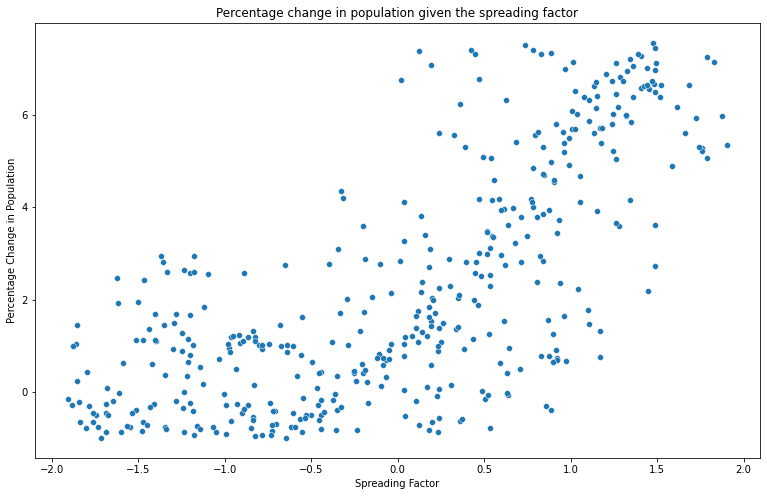

In [5]:
# We are told that the "Perc_population" column gives information about the change in percentage of the population
# and that the "Spreading_factor" column contains the spreading factor of bacteria populations

# We use Seaborn and Matplotlib to plot the scatter plot. 

plt.figure(figsize=(13,8))
fig = sns.scatterplot(data=bac_train, x="Spreading_factor", y="Perc_population", )
plt.title('Percentage change in population given the spreading factor')
fig.set_ylabel('Percentage Change in Population')
fig.set_xlabel('Spreading Factor');

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.2</b></div>

Based on the graph above, is there any discernable relationship between the spreading factor and percentage change in population?

_Points:_ 2

There seems to be an overall positive correlation between the spreading factor and the percentage change in the population. However, we notice that this is mainly the case for positive spreading factors: these are generally associated with higher percentage changes in population than for negative spreading factors. In this case, the higher the spreading factor, the higher the percentage change in bacteria population. Inversely, negative spreading factors are generally associated with shrinking bacteria populations (represented by a certain clustering below the 0 threshold on the y-axis, which is a negative percentage change in population). 

This suggests a relationship more appropriately explained via a higher degree polynomial, particularly of second degree. This ie because the percentage change in population seems to increase more rapidly forr higher rates of the spreading factor. 

<!-- END QUESTION -->

<a id="roadmap"></a>

<hr style='height:2px'> 

## Your Homework 3 roadmap

[Return to contents](#contents)

**We will be following this roadmap for Question 2 through Question 6:**

![](data/roadmap.png)


<a id="part2"></a>

## <div class='exercise'>Question 2: Guesstimate the polynomial relationship [14 pts]</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.1</b></div>

Based on your inspection in question 1, guesstimate the degree of the polynomial you believe would best fit the training while still generalizing well. Store this degree in the variable `guessed_deg`. 

Next, use `PolynomialFeatures()` to generate a design matrices of the guesstimated degree for the train and test data. Store these in `x_poly_train` and `x_poly_test`. **You should not include a bias in your design matrix.**

_Points:_ 2

In [6]:
# One may guess that the degree of the polynomial which would best fit the training data while still generalising
# well is 2

guessed_deg = 2

In [7]:
include_bias = False 

# Extracting predictor from both columns as a numpy array and reshaping it in order to fit and transform it

X_train = np.array(bac_train['Spreading_factor']).reshape(-1,1) 
X_test = np.array(bac_test['Spreading_factor']).reshape(-1,1)


y_train = np.array(bac_train['Perc_population']).reshape(-1,1)
y_test = np.array(bac_test['Perc_population']).reshape(-1,1)

# create the polynomial terms
poly = PolynomialFeatures(degree=guessed_deg, include_bias=include_bias)

x_poly_train = poly.fit_transform(X_train)
x_poly_test = poly.fit_transform(X_test)

In [8]:
# We note that number of columns is equal to the guessed degree

print(x_poly_train.shape)
print(x_poly_test.shape)

(423, 2)
(108, 2)


In [9]:
grader.check("q2.1")

q2.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.2</b></div>

Fit a polynomial regression using scikit-learn's `LinearRegression()` on the training design matrix. 

To track and compare the performance of each of the models in this notebook, use a list of dictionaries called `results`.

Each dictionary in this list will have the keys: 'model' (a string representing the question number where the model was fit), 'train_mse', and 'test_mse'.

So, for this question, you will append a dictionary to `results` of the form:
```python
{'model': '2.2', 'train_mse': 2.6749 'test_mse': 2.734}
```
Note that your MSE scores will not be the same as those in the example dictionary.

_Points:_ 2

In [10]:
# Fit a linear regression model


# Instantiating the linear regression:

fit_intercept = True # In this case, we fit intercept  
linreg = LinearRegression(fit_intercept=fit_intercept)

# Fitting a polynomial reression on the training design matrix and the training data:

linreg.fit(x_poly_train, y_train)


def get_metrics(model, name: str) -> dict:
    d = {}
    y_train_pred = model.predict(x_poly_train)
    y_test_pred = model.predict(x_poly_test)
    d['model'] = name
    d['train_mse'] = mean_squared_error(y_train, y_train_pred)
    d['test_mse'] = mean_squared_error(y_test, y_test_pred)
    return d

# Defining a results dictionary:

results = [get_metrics(linreg, '2.2')]
results

[{'model': '2.2',
  'train_mse': 2.661715130324049,
  'test_mse': 2.6748625754403093}]

In [11]:
grader.check("q2.2")

q2.2 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.3</b></div>

- Create a plot showing both the train and test data, as well as your model's prediction curve.
- Display `results` as a DataFrame.
- Explain the rationale for your choice of degree (i.e. your "guesstimation") and comment on the fit of your model.
  

_Points:_ 3

Upon examining the plot, the most likely approximation of the data would be a polynomial of second degree. 
This is because, the increase rate of "Perc_population" seems to have a quadratic relationship with "Spreading_factor" (one extremum visible). This significantly reduces the likelihood of a linear relationship as the growth rate in "Perc_population" is far from constant. This suggests that the growth rate (which is defined by the first derivative of the relating equation) depends on x. This is the characteristic of polynomial models. 

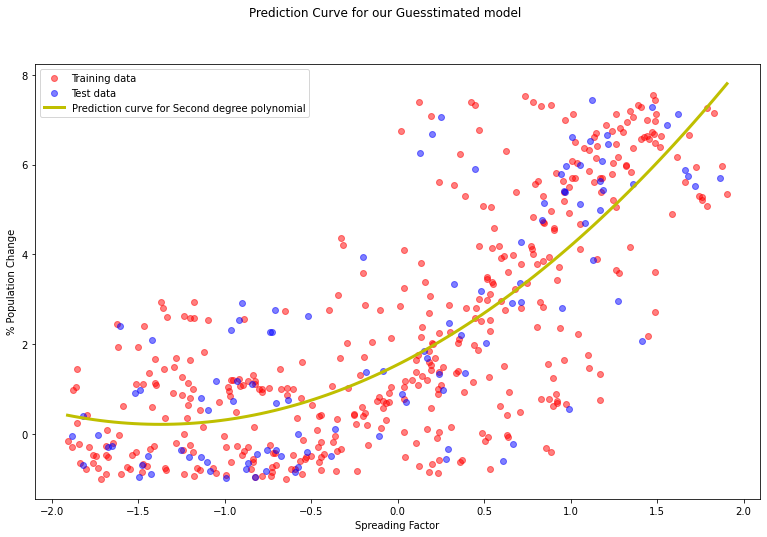

In [12]:
# We generate some data to predict on:

x = np.linspace(min(float(X_train.min()), float(X_test.min())), max(float(X_train.max()), float(X_test.max())), 100)

prediction = linreg.predict(
    poly.transform(x.reshape(-1, 1))
)


plt.figure(figsize = (13,8))
plt.scatter(x=X_train, y=y_train, color="r", label="Training data", alpha=0.5)
plt.scatter(x=X_test, y=y_test, color="b", label="Test data", alpha=0.5)
plt.plot(x, prediction, color="y", label=f"Prediction curve for Second degree polynomial", linewidth=3)
plt.xlabel("Spreading Factor")
plt.ylabel("% Population Change")
plt.legend()
plt.suptitle("Prediction Curve for our Guesstimated model");



In [13]:
# Storing the results as a DataFrame

results_df = pd.DataFrame(results).set_index('model')
results_df

,train_mse,test_mse
model,,
2.2,2.661715,2.674863


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.4</b></div>

Now we will compute confidence intervals for the coefficients generated by our model specification. For the same degree polynomial regression fit above in 2.2, compute and plot the 95% confidence interval of the beta (i.e. $\beta$) values obtained in that regression model. Be certain to meet these primary requirements:
- Report the coefficient values of the model fit above in 2.2.
- Use bootstrapping to generate your 95% confidence intervals by refitting your model to each bootstrapped sample of your training data. You should use **100 bootstrapped samples**.
- For each bootstrap, store the coefficients of the model, and use those stored coefficients to compute the $2.5$ and $97.5$ confidence bounds.
- Plot the bootstrapped coefficients as a grid of histograms, one histogram for each $\beta_i$, illustrating the distribution of bootstrapped coefficients for each $\beta_i$. Each distribution should indicate the regions of 95% confidence. Use `plt.subplots(...)` to arrange your histograms as a grid of plots.
- Comment on your findings.

**REMEMBER:** Bootstrapped samples should always be the same size as the original data and sampled with replacement.

_Points:_ 7

Bootstrapping enabled us to report the confidence intervals for our betas. Recall the beta coefficients from the previous parts reported below, we realise that they lie within the determined confidence intervals. This enables us to say with 95% confidence that the true values of our betas lie within this interval.

In [14]:
# Reporting coefficient values of model fit above:
linreg.fit(x_poly_train, y_train)
print("The coefficients that we obtain are: Beta_0:", linreg.intercept_[0], "Beta_1:", linreg.coef_[0][0], 'Beta_2:',linreg.coef_[0][1])

The coefficients that we obtain are: Beta_0: 1.5479189777983187 Beta_1: 1.9379680565747683 Beta_2: 0.7063789121219998


In [15]:
# We need to create 100 bootstrapped samples and store the resulting coefficients in lists that we define below:

n_boots = 100
beta_0s = []
beta_1s = []
beta_2s = []

for i in range(n_boots):
    
    # Creating a random sample with replacement
    random_indices = np.random.choice(bac_train.index, replace=True, size=len(bac_train))
    boots_df = bac_train.iloc[random_indices]
    X_train_bootstrap = boots_df[['Spreading_factor']]
    y_train_bootstrap = boots_df['Perc_population']

    # We construct our design matrices from our bootstrapped samples:
    x_train_poly_bootstrap = poly.transform(X_train_bootstrap)
    boot_strap_linear_regression = LinearRegression(fit_intercept=True) # Instantiate a new Linear Regression to fit on boots
    boot_strap_linear_regression.fit(x_train_poly_bootstrap, y_train_bootstrap) # fit on our new design matrices
    betas = boot_strap_linear_regression.coef_ # Retrieve our new betas from our new regressions

    # From each iteration, we store our new beta values into the lists defined above:
    beta_2s.append(betas[1]) # Beta 2
    beta_1s.append(betas[0]) # Beta 1
    beta_0s.append(boot_strap_linear_regression.intercept_) # Intercept



# Redefining our betas from the original linear regression:
beta_2 = linreg.coef_[0][1] 
beta_1 = linreg.coef_[0][0]
beta_0 = linreg.intercept_[0]


# Taking the mean of betas in our bootstrap samples:
beta2_avg_bootstrap = np.mean(beta_2s)
beta1_avg_bootstrap = np.mean(beta_1s)
beta0_avg_bootstrap = np.mean(beta_0)

# Using np.percentile to calculate our confidence intervals:

# At the 5% level:
beta_2_upper_CI_95 = np.percentile(beta_2s, 97.5)
beta_2_lower_CI_95 = np.percentile(beta_2s, 2.5)

beta_1_upper_CI_95 = np.percentile(beta_1s, 97.5)
beta_1_lower_CI_95 = np.percentile(beta_1s, 2.5)

beta_0_upper_CI_95 = np.percentile(beta_0s, 97.5)
beta_0_lower_CI_95 = np.percentile(beta_0s, 2.5)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without featu

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without featu

In [16]:
print('95% confidence intervals:')
print("95% CI for Beta_0:", [beta_0_lower_CI_95, beta_0_upper_CI_95])
print("95% CI for Beta_1:", [beta_1_lower_CI_95, beta_1_upper_CI_95])
print("95% CI for Beta_2:", [beta_2_lower_CI_95, beta_2_upper_CI_95])

95% confidence intervals:
95% CI for Beta_0: [1.3439334032503474, 1.8017991503639281]
95% CI for Beta_1: [1.76166685461203, 2.0668170617327233]
95% CI for Beta_2: [0.5169960709931535, 0.8299400320318667]


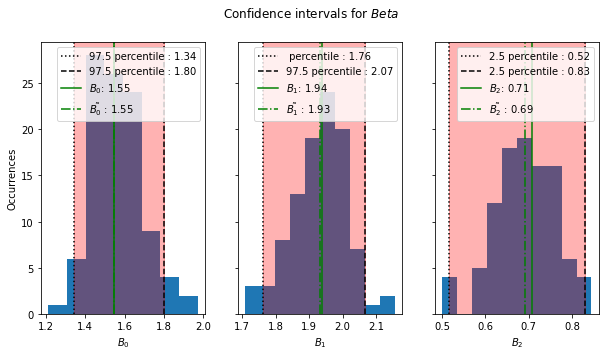

In [17]:
# We need to plot histograms for coefficients at the 95% level:

figure, ( ax_0, ax_1, ax_2) = plt.subplots(1, 3, sharey=True, figsize=(10, 5))

# Beta 2 Histogram:

ax_2.hist(beta_2s, bins=10)
ax_2.axvspan(beta_2_lower_CI_95, beta_2_upper_CI_95, color="r", alpha=0.3)
ax_2.axvline(
    beta_2_lower_CI_95,
    c="k",
    ls="dotted",
    label="2.5 percentile : {0:.2f}".format(beta_2_lower_CI_95),
)

ax_2.axvline(
    beta_2_upper_CI_95,
    c="k",
    ls="dashed",
    label="2.5 percentile : {0:.2f}".format(beta_2_upper_CI_95),
)
ax_2.axvline(
    beta_2,
    c="g",
    ls="solid",
    label="$B_{2}$:" + " {0:.2f}".format(beta_2),
)
ax_2.axvline(
    beta2_avg_bootstrap,
    c="g",
    ls="dashdot",
    label=r"$\tilde{B_{2}}$ :" + " {0:.2f}".format(beta2_avg_bootstrap),
)
ax_2.legend()
ax_2.set_xlabel("$B_{2}$")


# Beta 1 histogram:

ax_1.hist(beta_1s, bins=10)
ax_1.axvspan(beta_1_lower_CI_95, beta_1_upper_CI_95, color="r", alpha=0.3)
ax_1.axvline(
    beta_1_lower_CI_95,
    c="k",
    ls="dotted",
    label=" percentile : {0:.2f}".format(beta_1_lower_CI_95),
)
ax_1.axvline(
    beta_1_upper_CI_95,
    c="k",
    ls="dashed",
    label="97.5 percentile : {0:.2f}".format(beta_1_upper_CI_95),
)
ax_1.axvline(
    beta_1,
    c="g",
    ls="solid",
    label="$B_{1}$:" + " {0:.2f}".format(beta_1),
)
ax_1.axvline(
    beta1_avg_bootstrap,
    c="g",
    ls="dashdot",
    label=r"$\tilde{B_{1}}$ :" + " {0:.2f}".format(beta1_avg_bootstrap),
)
ax_1.legend()
ax_1.set_xlabel("$B_{1}$")


# Beta 0 histogram:
ax_0.hist(beta_0s, bins=8)
ax_0.axvspan(beta_0_lower_CI_95, beta_0_upper_CI_95, color="r", alpha=0.3)
ax_0.axvline(
    beta_0_lower_CI_95,
    c="k",
    ls="dotted",
    label="97.5 percentile : {0:.2f}".format(beta_0_lower_CI_95),
)
ax_0.axvline(
    beta_0_upper_CI_95,
    c="k",
    ls="dashed",
    label="97.5 percentile : {0:.2f}".format(beta_0_upper_CI_95),
)

ax_0.axvline(
    beta_0,
    c="g",
    ls="solid",
    label="$B_{0}$:" + " {0:.2f}".format(beta_0),
)
ax_0.axvline(
    beta0_avg_bootstrap,
    c="g",
    ls="dashdot",
    label=r"$\tilde{B_{0}}$ :" + " {0:.2f}".format(beta0_avg_bootstrap),
)
ax_0.legend()
ax_0.set_xlabel("$B_{0}$");
ax_0.set_ylabel("Occurrences")

figure.suptitle("Confidence intervals for $Beta$");

<!-- END QUESTION -->

<a id="part3"></a>

## <div class='exercise'>Question 3: Single validation set [12 pts]</div> 

In this section you'll find the best degree polynomial relationship using a single validation set.

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.1</b></div>

Split your original training data such that you separate out 20% into a single validation split. Use `random_state=1` and save the resulting splits as `x_train80`, `x_val`, `y_train80`, `y_val`. (This will prevent the overwriting of the original train data variables).

_Points:_ 1

In [18]:
# Making sure we are passing them in as arrays:

X = np.array(bac_train['Spreading_factor'])
y = np.array(bac_train['Perc_population'])

In [19]:
x_train80, x_val, y_train80, y_val = train_test_split(X_train,y_train,train_size=0.8,random_state=1)

In [20]:
grader.check("q3.1")

q3.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.2</b></div>

- Fit polynomial regression models for **degrees 1 to 30 (inclusive)** on the 80% training set (one model for each degree polynomial regression).
- Store the train and validation MSE values for each model in lists called `train_mses` and `val_mses`.

_Points:_ 2

In [21]:
# To iterate over the range, we select the maximum degree of the polynomial
maxdeg = 30
degrees = range(1, maxdeg+1)

# Create two empty lists to store training and validation MSEs
train_mses, val_mses = [],[]

for d in degrees:
    
    # Creating design matrices:
    polynomial = PolynomialFeatures(degree= d, include_bias=False)
    x_train80_poly = polynomial.fit_transform(x_train80)
    x_val_poly = polynomial.transform(x_val)

    # Fitting Linear Regression model:
    lr80 = LinearRegression()
    lr80.fit(x_train80_poly, y_train80)

    # Computing predictions:
    y_train_pred = lr80.predict(x_train80_poly)
    y_val_pred = lr80.predict(x_val_poly)
    
    # Computing MSEs:
    train_mse = mean_squared_error(y_train80, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    
    # Appending values to lists:
    train_mses.append(train_mse)
    val_mses.append(val_mse)

In [22]:
grader.check("q3.2")

q3.2 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.3</b></div>

- Generate a single plot illustrating the train and validation $MSE$ values for each fitted degree polynomial regression model.
- Identify and report the degree for which the validation error is lowest.

**Note:** Plotting the MSE on a log scale may be helpful.

_Points:_ 4

In [23]:
# Compute the best degree, which is the model with the 
# lowest validation error

# Identifying
min_mse = min(val_mses)
best_degree = val_mses.index(min_mse) + 1 # Because we use the "range" function

# Print the degree of the best model computed above
print("The best degree of the model is", best_degree, 'with a minimum Validation MSE of', min_mse)

The best degree of the model is 15 with a minimum Validation MSE of 2.8801904306464636


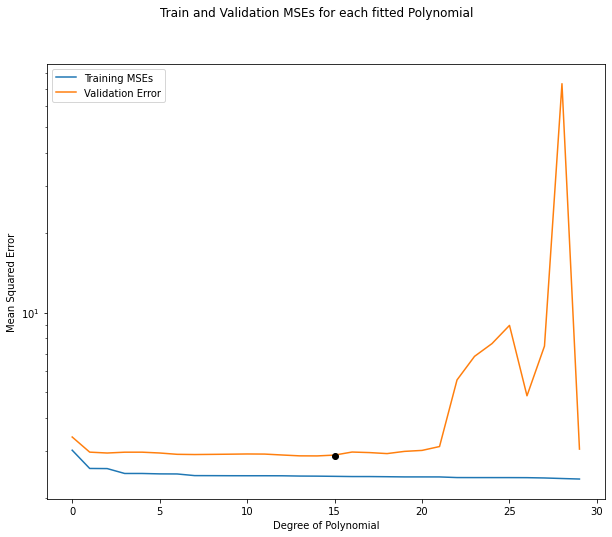

In [24]:
fig, ax = plt.subplots(figsize=(10,8))

# Plot the training error with labels
ax.plot(range(maxdeg), train_mses , label="Training MSEs")

# Plot the validation error with labels
ax.plot(range(maxdeg), val_mses, label = "Validation Error")

# Set the plot labels and legends
ax.set_xlabel('Degree of Polynomial')
ax.set_ylabel('Mean Squared Error')
ax.legend(loc = 'best')
ax.set_yscale('log')

plt.scatter(x=best_degree, y=min_mse, 
            c="k", zorder=3)

plt.suptitle('Train and Validation MSEs for each fitted Polynomial')
plt.show();

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.4</b></div>

Now, with the best degree selected, train the polynomial regression on the **complete training set** (including the observations that you had previously removed to make the validation set). 

Append a new dictionary to your `results` list for this model.

_Points:_ 3

In [25]:
include_bias = False 

# Extracting predictor from both columns as a numpy array and reshaping it in order to fit and transform it

# create the polynomial terms
poly = PolynomialFeatures(degree=best_degree, include_bias=include_bias)

# We need to repeat the same steps as previously to take into acccount the "best degree"

x_poly_train = poly.fit_transform(X_train)
x_poly_val = poly.transform(X_test)

# Fitting the model we instantiated above on the train data:

linreg = LinearRegression(fit_intercept=True)
linreg.fit(x_poly_train, y_train)

# make predictions
y_train_pred = linreg.predict(x_poly_train)
y_test_pred = linreg.predict(x_poly_val)



def get_metrics2(model, name: str) -> dict:
    d = {}
    d['model'] = name
    d['train_mse'] = mean_squared_error(y_train, y_train_pred)
    d['test_mse'] = mean_squared_error(y_test, y_test_pred)
    return d

results.append(get_metrics2(linreg, '3.4'))

In [26]:
results

[{'model': '2.2',
  'train_mse': 2.661715130324049,
  'test_mse': 2.6748625754403093},
 {'model': '3.4',
  'train_mse': 2.490945608870453,
  'test_mse': 2.7364825064085667}]

In [27]:
grader.check("q3.4")

q3.4 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.5</b></div>

Generate a plot of the data and your regression curve (similar to [Question 2.3](#part2)). Comment on how your model fits the data and compare it to the fit of your "guesstimated" model from [Question 2](#part2solutions).

_Points:_ 2

With a higher degree polynomial, the model fits the training data better (actually, almost perfectly). However, it struggles to perform well on the testing data. This is representative of overfitting. 

,train_mse,test_mse
model,,
2.2,2.661715,2.674863
3.4,2.490946,2.736483


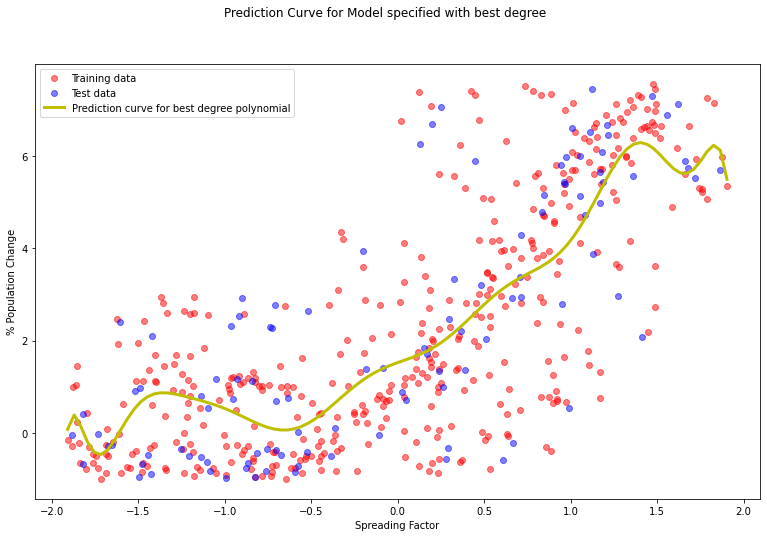

In [28]:
# We generate some data to predict on:

x = np.linspace(min(float(X_train.min()), float(X_test.min())), max(float(X_train.max()), float(X_test.max())), 100)

prediction = linreg.predict(
    poly.transform(x.reshape(-1, 1))
)


plt.figure(figsize=(13,8))
plt.scatter(x=X_train, y=y_train, color="r", label="Training data", alpha=0.5)
plt.scatter(x=X_test, y=y_test, color="b", label="Test data", alpha=0.5)
plt.plot(x, prediction, color="y", label=f"Prediction curve for best degree polynomial", linewidth=3)
plt.xlabel("Spreading Factor")
plt.ylabel("% Population Change")
plt.legend()
plt.suptitle("Prediction Curve for Model specified with best degree");

results_df = pd.DataFrame(results).set_index('model')
results_df

<a id="part4"></a>

## <div class='exercise'>Question 4: Finding the best model by k-fold cross validation [14 pts]</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.1</b></div>

In this part we find the best degree polynomial regression by running the model on a range of degree values and using k-fold cross validation. Note that `cross_validation` should be passed *all* training examples (*not* the 80% split from the previous question).

- Use scikit-learn's `cross_validate(...)` to perform cross validation with $k=10$ for each polynomial regression from **degree 1 to 30 (inclusive)**.
- For each degree:
    - store the mean train MSE across all $k$ folds in the list `train_mses_mean`
    - store the mean validation MSE across all $k$ folds in the list `val_mses_mean`
    - store the standard deviation  of the validation MSE across all $k$ folds in the list `val_mses_std`
    

_Points:_ 4

In [29]:
# We conduct a train test split with all validation samples, train_size=1:

X_train_cv, x_val_cv, y_train_cv, y_val_cv = train_test_split(X,y, train_size=1, random_state=1) 

In [30]:
X = X.reshape(-1,1)
X_train_cv = X_train_cv.reshape(-1, 1)
x_val_cv = x_val_cv.reshape(-1,1)

In [31]:
# To iterate over the range, select the maximum degree of the polynomial
maxdeg = 30

# Create three empty lists to store training, validation and cross-validation MSEs
train_mses_mean, val_mses_mean, val_mses_std, cross_val_mses_mean, cross_val_train_mses_mean  = [],[],[],[], []

# Loop through the degrees of the polynomial
for d in range(maxdeg):
    
    # Compute the polynomial features for the entire data
    x_poly_cv = PolynomialFeatures(d).fit_transform(X)

    # Compute the polynomial features for the train data
    x_poly_train_cv = PolynomialFeatures(d).fit_transform(X_train_cv)

    # Compute the polynomial features for the validation data
    x_poly_val_cv = PolynomialFeatures(d).fit_transform(x_val_cv)

    # Fit model on the training set
    linreg.fit(x_poly_train_cv, y_train_cv)

    # Predict on the training data
    y_train_pred_cv = linreg.predict(x_poly_train_cv)

    # Predict on the validation set
    y_val_pred_cv = linreg.predict(x_poly_val_cv)
    
    # Compute the mse on the train data
    train_mses_mean.append(mean_squared_error(y_train_cv, y_train_pred_cv))

    # Compute the mse on the validation data
    val_mses_mean.append(mean_squared_error(y_val_cv, y_val_pred_cv))

    # Perform cross-validation on the entire data with 10 folds and 
    # get the mse_scores
    mse_score = cross_validate(linreg, x_poly_cv, y, cv=10, scoring="neg_mean_squared_error", return_train_score=True )
    
    # Compute the mean of the cross validation error and store in list 
    # Remember to take into account the sign of the MSE metric returned by the cross_validate function 
    val_mses_std.append(np.std(mse_score['test_score']))
    cross_val_mses_mean.append(-1*np.mean(mse_score['test_score']))
    
    cross_val_train_mses_mean.append(-1*np.mean(mse_score['train_score']))

In [32]:
grader.check("q4.1")

q4.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.2</b></div>

- Generate a single plot showing the mean train and validation $MSE$ values (see note below) for each degree polynomial regression, including the +/- 1 standard deviation bounds for the validation $MSE$ values.
- Comment on trends and findings illustrated by your plot.
- Print the degree of the best model, identified based on the lowest mean validation $MSE$, along with the corresponding mean train and validation $MSE$ values.

**NOTE:** When we refer to train and validation $MSE$ values here in Question 4.2 and in future problems where we are performing cross validation, we are referring specifically to the cross-validation generated train and validation $MSE$ values. Just please remember, when accessing your validation $MSE$ values while performing cross validation with scikit-learn's `cross_validate(...)`, scikit-learn rather confusingly refers to its validation scores as `test_score` in the dictionary that it returns, even though those values are actually validation scores. Please see the `cross_validate(...)` [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) for more info on this function.

_Points:_ 4

Increasing number of decrees seems to be accompanied with an overall decrease in train MSE, but increase in validation MSE. 

A decrease in train MSE that accompanies an increase in the degrees of the model (model complexity). This follows from the fact that as degrees increase, the fitting of the training data improves, which will most likely cause overfitting down the line. This is because the bias is decreasing. 
The more you overfit the training data, the less the model is able to generalise to the validation data. This explains the positive correlation between validation MSE and degrees. The model starts fitting the training data better and better as degrees increase, reducing its predictive capacities on brand new data. 

In [33]:
# Get the best degree associated with the lowest cross-validation error
min_cross_val_mse = min(cross_val_mses_mean)
best_cross_val_degree = cross_val_mses_mean.index(min_cross_val_mse)
best_train_mse_degree = cross_val_train_mses_mean[np.argmin(cross_val_mses_mean)]

# Print the values
print("The best degree of the model using cross-validation is",best_cross_val_degree)
print('The best validation MSE is', min_cross_val_mse)
print('The best mean train MSE is', best_train_mse_degree)

The best degree of the model using cross-validation is 8
The best validation MSE is 2.5990753511998586
The best mean train MSE is 2.5081491803463067


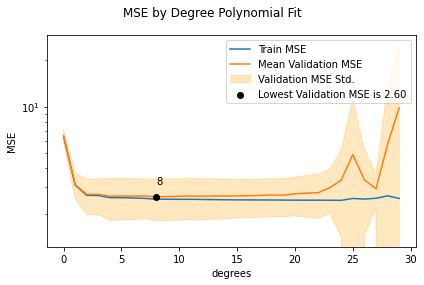

In [34]:
plt.plot(range(maxdeg), cross_val_train_mses_mean, label="Train MSE")
plt.plot(range(maxdeg), cross_val_mses_mean, label="Mean Validation MSE")

# We want the plot to highlight the standard deviations, for this we use "fill_between"
plt.fill_between(range(maxdeg), 
                y1 = np.array(cross_val_mses_mean) + np.array(val_mses_std), 
                y2 = np.array(cross_val_mses_mean) - np.array(val_mses_std),
                color = "orange", 
                alpha=0.25,
                label="Validation MSE Std."
                )

# We identify best fitting degree for validation MSE
min_cross_val_mse = min(cross_val_mses_mean)
best_cross_val_degree = cross_val_mses_mean.index(min_cross_val_mse)


plt.scatter(best_cross_val_degree, min_cross_val_mse, c='k', zorder=3, label="Lowest Validation MSE is {0:.2f}".format(min_cross_val_mse))
plt.annotate(best_cross_val_degree, xy =(best_cross_val_degree, min_cross_val_mse * 1.20))
plt.yscale("log")
plt.xlabel("degrees")
plt.ylabel("MSE")
plt.suptitle("MSE by Degree Polynomial Fit")
plt.legend();
plt.tight_layout()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.3</b></div>

Fit the best model based on the entire training data and report the $MSE$.


- For the best degree polynomial regression identified in Question 4.2 above, train on the complete training data and predict on the test data.
- Append a new dictionary for this model to the `results` list. 

_Points:_ 4

In [35]:
best_fit_degree = 8

# Defining a new design matrix for the best fitting degree:

polynomial = PolynomialFeatures(degree= best_fit_degree, include_bias=False)
x_train_poly = polynomial.fit_transform(X_train)
x_val_poly = polynomial.transform(X_test)

# fit linear regression 
linreg = LinearRegression(fit_intercept=True)
linreg.fit(x_train_poly, y_train)

# make predictions
y_train_pred = linreg.predict(x_train_poly)
y_test_pred = linreg.predict(x_val_poly)



def get_metrics3(model, name: str) -> dict:
    d = {}
    d['model'] = name
    d['train_mse'] = mean_squared_error(y_train, y_train_pred)
    d['test_mse'] = mean_squared_error(y_test, y_test_pred)
    return d

get_metrics3(linreg, '4.3')

results.append(get_metrics3(linreg, '4.3'))

results

[{'model': '2.2',
  'train_mse': 2.661715130324049,
  'test_mse': 2.6748625754403093},
 {'model': '3.4',
  'train_mse': 2.490945608870453,
  'test_mse': 2.7364825064085667},
 {'model': '4.3',
  'train_mse': 2.5125174574727875,
  'test_mse': 2.613010637353015}]

In [36]:
grader.check("q4.3")

q4.3 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.4</b></div>

- Generate a plot of the data and your regression curve (similar to [Question 2.3](#part2)).
- Display the coefficients of your model.
- Display `results` as a DataFrame (there should now be 3 entries).
- Comment on how your model fits the data and how your model compares relative to the prior best-fit model you generated using just a single validation set in [Question 3](#part3solutions).

_Points:_ 2

A higher train MSE and lower test MSE shows that this model shows that the model does not fit the data as well, but tends to generalise better to the testing data. k-fold cross-validation reassures us in this sense as it gives us insight into the true skills of this model applied to folds of new data. Overfitting seems like less of an issue in this case.

In [37]:
print('Coefficients of model are:')
for i in [i for i in linreg.coef_]:
    print(i)
    
print('Intercept is:')
print(linreg.intercept_)

Coefficients of model are:
[ 2.59702778 -1.09486847 -1.18913441  3.48314914  0.65287664 -1.71300787
 -0.11530516  0.24041837]
Intercept is:
[1.53533357]


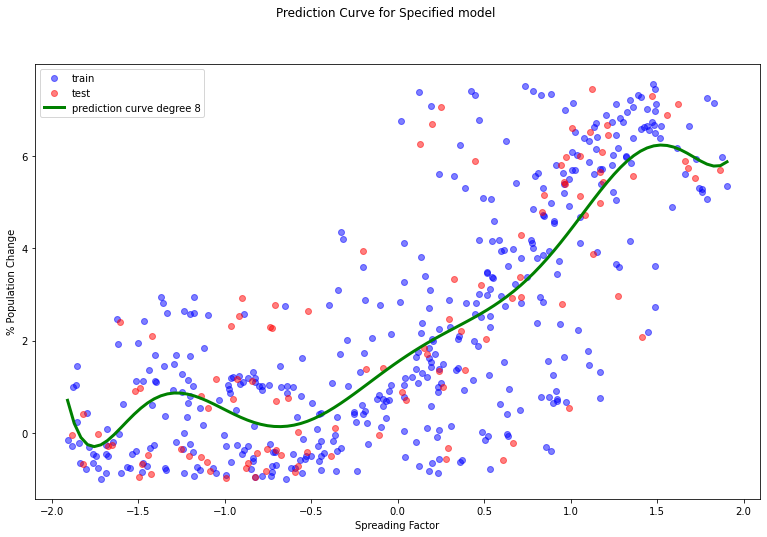

In [38]:
# We generate some data to predict on:

# make mock data for our prediction curve
x_range = np.linspace(min(float(X_train.min()), float(X_test.min())), max(float(X_train.max()), float(X_test.max())), 100)




prediction_curve = linreg.predict(
    polynomial.transform(x_range.reshape(-1, 1))
)


plt.figure(figsize=(13,8))
plt.scatter(x=X_train, y=y_train, color="b", label="train", alpha=0.5)
plt.scatter(x=X_test, y=y_test, color="r", label="test", alpha=0.5)
plt.plot(x_range, prediction_curve, color="g", label=f"prediction curve degree {best_fit_degree}", linewidth=3)
plt.xlabel("Spreading Factor")
plt.ylabel("% Population Change")
plt.legend()
plt.suptitle(f"Prediction Curve for Specified model");


In [39]:
# Storing the results as a DataFrame

results_df = pd.DataFrame(results).set_index('model')
results_df

,train_mse,test_mse
model,,
2.2,2.661715,2.674863
3.4,2.490946,2.736483
4.3,2.512517,2.613011


<!-- END QUESTION -->

<a id="part5"></a>

## <div class='exercise'>Question 5: Finding the most consistent model using k-fold cross validation with bootstraps [16 pts]</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q5.1</b></div>

In the previous part, we used $k$-fold cross validation to find the best model. But how confident are you of your estimated best degree? We have already used bootstraps in [Question 2.4](#part2) to estimate the confidence intervals of our $\beta_i$ values. In this segment, we will use bootstrapping to test the robustness of our estimation.

- Similar to Question 2.4, **use 100 bootstraps** of your data.
- For each bootstrap:
  - Use scikit-learn's `cross_validate(...)` to perform cross validation with $k=10$ *for each polynomial regression* of **degrees 1 to 30 (inclusive)**.
  - Select the best degree polynomial based on the lowest mean cross-validation MSE and store this degree in a list called `best_degrees`.
- After completing your bootstraps, `best_degrees` should have 100 elements, one degree for each completed bootstrap.

**NOTE:** Once complete, your code for this problem will likely take several minutes to execute. This is to be expected.

_Points:_ 4

In [40]:
# create 100 bootstrapped samples and store the resulting coefficients 
n_boots = 100

degrees = range(1, maxdeg+1)
best_degrees = []  # Defining a list to store the best degree for each sample

# create a random sample with replacement (bootstrapping)
for sample in range(n_boots):
    random_indices = np.random.choice(bac_train.index, replace=True, size=len(bac_train))
    boots_df = bac_train.iloc[random_indices]
    X_train_bootstrap = boots_df[['Spreading_factor']]
    y_train_bootstrap = boots_df['Perc_population']

    validation_mses_mean = []

    for d in degrees:
        
        # construct design matrices
        polynomial = PolynomialFeatures(degree= d, include_bias=False)
        x_train_poly_bootstrap = polynomial.fit_transform(X_train_bootstrap)

        # define linear model
        boot_strap_linear_regression = LinearRegression(fit_intercept=True)

        # cross validate 
        mse_scores = cross_validate(boot_strap_linear_regression, x_train_poly_bootstrap, y_train_bootstrap, 
                                    cv=10, scoring="neg_mean_squared_error", return_train_score=True)

        # take the mean MSE for every degree polynomial                            
        validation_mses_mean.append(np.mean(mse_scores["test_score"] * -1))

    best_degree = np.argmin(validation_mses_mean) + 1
    best_degrees.append(int(best_degree))
    
assert(len(best_degrees) == 100) # Confirming that we indeed have 100 best degrees.

In [41]:
grader.check("q5.1")

q5.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q5.2</b></div>

Generate a well-labeled bar plot, with the polynomial degree on the $x$-axis and the number of times that degree was deemed best on the $y$-axis, using the `best_degrees` saved during your bootstraps.

_Points:_ 4

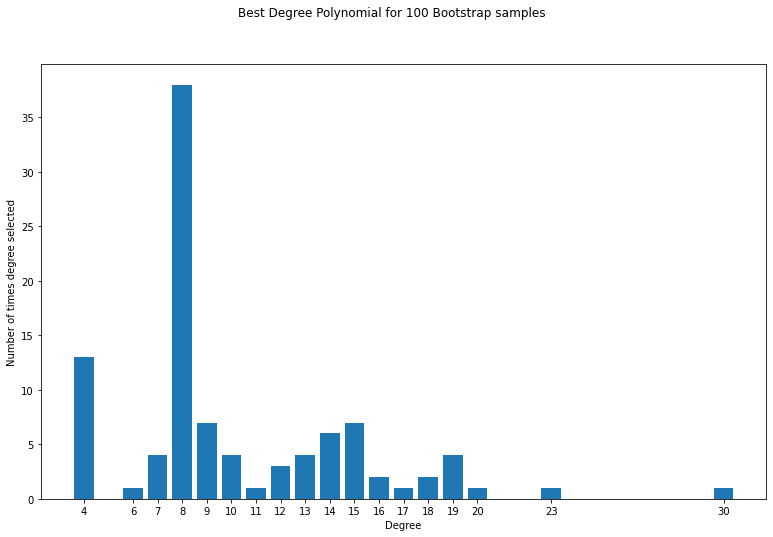

In [42]:
# We need to count the amount of times a certain degree was selected as "the best"

# For this, we use a counter function
counter = Counter(best_degrees)
df = pd.DataFrame(counter.items(), columns= ["Degree", "Num times selected"]).sort_values("Num times selected", ascending=False)


plt.figure(figsize=(13,8))
plt.bar(df["Degree"], df["Num times selected"], tick_label = df["Degree"])
plt.ylabel("Number of times degree selected")
plt.xlabel("Degree")
plt.suptitle("Best Degree Polynomial for 100 Bootstrap samples");

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q5.3</b></div>

What are your observations from the plot above? 


_Points:_ 3

One needs to recall here that bootstraps are independent samples from the dataframe, meaning that they do not represent the same sample each time, and constitute completely different data. Essentially, this is equivalent to modifying the training data 100 times, which is why the "best degree" will also change, as it is adapted to each particular training set.

We should choose the degree that has the lowest MSE independently of the the boostrap sample. A quick look at the plot shows that this is 8, which is selected 43 times. 



<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q5.4</b></div>

Now, with the overall best degree identified with your bootstrapping results above, train the polynomial regression model on the **complete training set**. Append a new dictionary for this model to your `results` list. 

_Points:_ 3

In [43]:
best_degree_overall = 8

# Defining a new design matrix for the best fitting degree:

polynomial = PolynomialFeatures(degree= best_degree_overall, include_bias=False)
x_train_poly = polynomial.fit_transform(X_train)
x_val_poly = polynomial.transform(X_test)

# fit linear regression 
linreg = LinearRegression(fit_intercept=True)
linreg.fit(x_train_poly, y_train)

# make predictions
y_train_pred = linreg.predict(x_train_poly)
y_test_pred = linreg.predict(x_val_poly)

# calculate MSE
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

results.append({"model": "5.4", "train_mse": train_mse, "test_mse": test_mse})

results

[{'model': '2.2',
  'train_mse': 2.661715130324049,
  'test_mse': 2.6748625754403093},
 {'model': '3.4',
  'train_mse': 2.490945608870453,
  'test_mse': 2.7364825064085667},
 {'model': '4.3',
  'train_mse': 2.5125174574727875,
  'test_mse': 2.613010637353015},
 {'model': '5.4',
  'train_mse': 2.5125174574727875,
  'test_mse': 2.613010637353015}]

In [44]:
grader.check("q5.4")

q5.4 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q5.5</b></div>

- Generate a plot of the data and your regression curve.
- Display `results` as a DataFrame.
- Comment on how your model fits the data and compare it to the fit of your cross-validated model from [Question 4](#part4solutions).

_Points:_ 2

One may argue that the curve fits the data quite closely. One may note here that the fit is the same as the model from part 4. This is because we have fit polynomials of the same degree on the data. 

In [45]:
results_df = pd.DataFrame(results).set_index('model')
results_df

,train_mse,test_mse
model,,
2.2,2.661715,2.674863
3.4,2.490946,2.736483
4.3,2.512517,2.613011
5.4,2.512517,2.613011


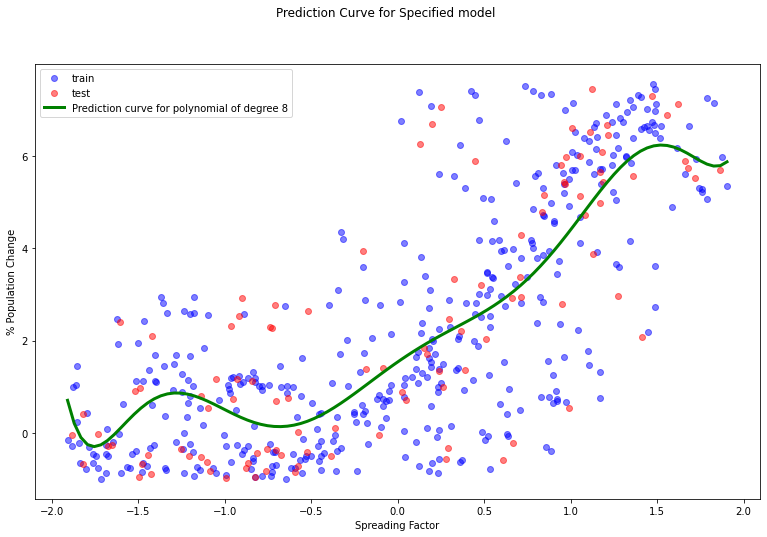

In [46]:
# We generate some data to predict on:

# make mock data for our prediction curve
x_range = np.linspace(min(float(X_train.min()), float(X_test.min())), max(float(X_train.max()), float(X_test.max())), 100)



polynomial = PolynomialFeatures(degree= best_degree_overall, include_bias=False)
x_train_poly = polynomial.fit_transform(X_train)
x_val_poly = polynomial.transform(X_test)

linreg = LinearRegression()
linreg.fit(x_train_poly, y_train)


prediction_curve = linreg.predict(
    polynomial.transform(x_range.reshape(-1, 1))
)


plt.figure(figsize=(13,8))
plt.scatter(x=X_train, y=y_train, color="b", label="train", alpha=0.5)
plt.scatter(x=X_test, y=y_test, color="r", label="test", alpha=0.5)
plt.plot(x_range, prediction_curve, color="g", label=f"Prediction curve for polynomial of degree {best_fit_degree}", linewidth=3)
plt.xlabel("Spreading Factor")
plt.ylabel("% Population Change")
plt.legend()
plt.suptitle(f"Prediction Curve for Specified model");

<!-- END QUESTION -->

<a id="part6"></a>

## <div class='exercise'>Question 6: Improving model consistency with LASSO regularization [33 pts]</div> 

[Return to contents](#contents)

In the previous sections, we compared many polynomial models to find the best degree. For each model of degree $n$, we considered all polynomial coefficients *up to and including* **degree $n$** using `PolynomialFeatures(...)`. In this section we will consider polynomial features of $n=30$, and a **best model** that could be chosen from any possible combination of our 30 degrees.

For instance, we could choose a best model with an arbitrary set of polynomial degrees up degree 30, such as $x^i \in [x^1, x^5, x^{19}, x^{24}]$, rather than the standard approach of using *all* consecutive degrees up to our maximum degree $n=30$ as in $x^i \in [x^1, ... , x^{30}]$.

However, the total number of such possible models for $n=30$ is $2^{30}\approx10^9$, and searching through all of them would be laborious and computationally inefficient. Instead, we can use $LASSO$ (i.e. $L1$) regularization, which "switches off" highly unstable degree coefficients by shrinking them to zero (or very close to zero), thus giving us an efficient solution to this particular combinatorial challenge.

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q6.1</b></div>

**Find the best hyper-parameter alpha, $\alpha$**

Use the `LassoCV` estimator to find the best regularization parameter from $\alpha \in [10^{-5}, 10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}]$
- Store the mean cross-validation MSEs across each fold in `lassoCV_val_mses_mean`
- Save the best $\alpha$ based on the mean cross-validation MSE in `best_alpha`

You should read the documentation for [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html). Some important information about this estimator:
- After calling `fit`, the model is now the one fit on the entire training data using the best alpha based on the mean CV MSE.
- the `mse_path_` attribute contains the validation scores on each fold for each candidate alpha.
- the `alpha_` attribute contains the best regularization parameter found through cross-validation

**Tips:** You should try adjusting `LassoCV`'s `max_iter` argument to prevent convergence warnings. If you are unable to prevent them with a large number of iterations (~100,000) then you can silence them with:
```{python}
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
```
Do not worry about normalizing your $x$ values for any parts of Question 6. It will not meaningfully affect our final results here.

_Points:_ 5

In [47]:
values_of_alpha = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1,]

# Creating a design matrix, as previously:
poly = PolynomialFeatures(30, include_bias=False)
x_poly_train = poly.fit_transform(X_train)

lasso_ = LassoCV(fit_intercept=True, alphas=values_of_alpha, cv=10,  max_iter=100_000)

lasso_.fit(x_poly_train, y_train)


best_alpha = float(lasso_.alpha_)

#lassoCV_val_mses_mean = [np.mean(mses) for mses in lasso_regression.mse_path_]

lassoCV_val_mses_mean = []

for mses in lasso_.mse_path_:
    lassoCV_val_mses_mean.append(np.mean(mses))
    

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [48]:
grader.check("q6.1")

q6.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q6.2</b></div>

Generate two plots:
- One showing the mean validation $MSE$ values for each regularization parameter $\alpha$, identifying the best $\alpha$.
- Another showing the values for each of the model's coefficients. 

_Points:_ 5

In [49]:
alphas = LassoCV.path(x_poly_train, y_train, alphas=values_of_alpha)[0]
coefficients = LassoCV.path(x_poly_train, y_train, alphas=values_of_alpha)[1]
_ = LassoCV.path(x_poly_train, y_train, alphas=values_of_alpha)[2]

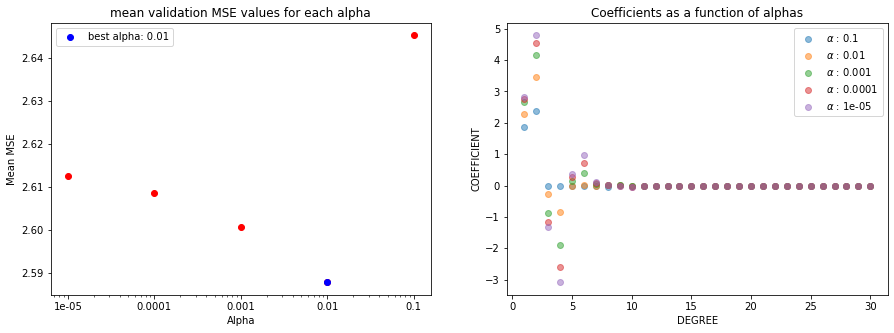

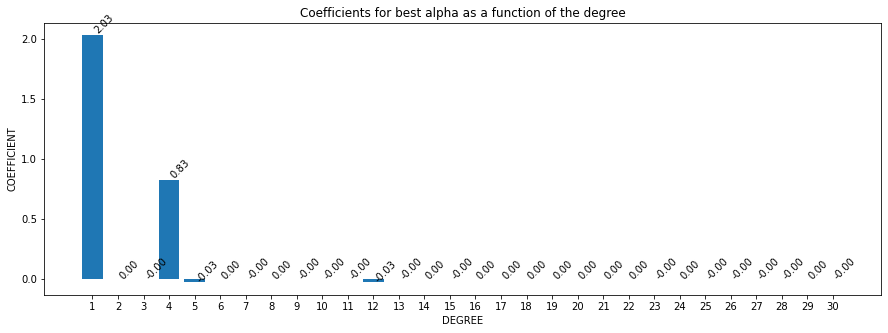

In [50]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15,5))



# Finding the index of the best alphas
best_alpha_index = np.where(lasso_.alphas_ == best_alpha)[0][0]
ax1.scatter(lasso_.alphas_, lassoCV_val_mses_mean, c="r")
ax1.scatter(lasso_.alpha_, lassoCV_val_mses_mean[best_alpha_index], c="b", label= rf"best alpha: {best_alpha}")
ax1.set_xscale("log")
ax1.set_xlabel("Alpha")
ax1.set_ylabel("Mean MSE")
ax1.set_xticks(alphas);
ax1.set_xticklabels(alphas);
ax1.legend();
ax1.set_title(r"mean validation MSE values for each alpha");

 
for i, coeffs in enumerate(coefficients.T):
    ax2.scatter(range(1,len(coeffs)+1), coeffs, label = rf"$\alpha$ : {alphas[i]}", alpha=0.5)

ax2.set_xlabel("DEGREE")
ax2.set_ylabel("COEFFICIENT")
ax2.set_title(r"Coefficients as a function of alphas");
ax2.legend();

fig, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(15,5))

ax3.bar(range(1,len(coeffs)+1), lasso_.coef_)

for x,y in zip(range(1,len(coeffs)+1), lasso_.coef_):
    ax3.annotate('{0:.2f}'.format(y), (x - (x*.001),y + (y*0.01)), rotation=45)
ax3.set_ylabel("COEFFICIENT")
ax3.set_xlabel("DEGREE")
ax3.set_title(r"Coefficients for best alpha as a function of the degree")
ax3.set_xticks(range(1,len(coeffs)+1));

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q6.3</b></div>

**Find the most significant degrees**

**NOTE: The code for this question has been provided. It can take several minutes to run. Just be sure to answer the interpretation part of the question.**

From the previous section, you will now have the `best_alpha` hyperparameter. Now, we will use this best $\alpha$ value to find the "most significant" set of polynomial degrees by using bootstraps.

What we mean by this is, for each bootstrap of the data, you will get some set of degrees that are **significant**, as will be indicated by the value of their coefficients. Typically, while using $LASSO$ regularization, we would consider $\mid\beta_i\mid \gt 0$ as an indication of a particular coefficient's significance. However, for this particular exercise, we are going to use $\mid\beta_i\mid \gt 0.1$ as our criteria for significance (we have found this $0.1$ threshold to work well when designing this particular problem).

Based on this criteria, you will identify which degree coefficients are significant over many bootstrapped iterations with $n=30$ polynomial features and your chosen best $\alpha$ from Question 6.1.

- Use polynomial features with **degree 30**.
- Use a dictionary called `significant_degrees` to store a cumulative count for each degree identified as significant during your bootstraps.
- Run at least 100 bootstraps of your data.
- For each bootstrap:
  - Train a `Lasso(...)` model with the `best_alpha` identified in Question 6.1.
  - Identify the significant polynomial degree coefficients using $\mid\beta_i\mid \gt 0.1 $ as our threshold for significance.
  - For each significant coefficient, update the count of that degree in your `significant_degrees` dictionary.
- Generate a bar plot showing the count for each degree, showing how many times it was identified as significant over your bootstraps.
- Based on this plot, there should likely be a clear maximum degree, above which, few if any iterations have been identified as significant. Interpret your bar plot, choose a maximum degree polynomial based upon it, and explain your rationale for choosing that degree.

_Points:_ 5

This bar plot shows the count for each degree, and shows how many times it was identified as significant over our bootstraps. 10 is the last degree at which any iterations are deemed significant, which is why we should choose it. 

In [51]:
# Setting bootstrap parameters
numboot = 100
max_degree = 30
include_bias = False
fit_intercept = True
max_iter = 100000

# Creating empty dictionary to store results
significant_degrees = {}


df_train = pd.read_csv('/Users/jamesliounis/Downloads/cs109a_hw3-2/data/bacteria_train.csv')
for i in range(numboot):
    df_boot = df_train.sample(frac=1, replace=True)
    x_train_boot = df_boot[["Spreading_factor"]]
    x_poly_train = PolynomialFeatures(
        max_degree, include_bias=include_bias
    ).fit_transform(x_train_boot)
    y_train_boot = df_boot.Perc_population

    lasso = Lasso(
        fit_intercept=fit_intercept,
        max_iter=max_iter,
        alpha=best_alpha,
    )
    lasso.fit(x_poly_train, y_train_boot)
    
    if fit_intercept==True:
        coefficients = [lasso.intercept_, *lasso.coef_]
    else:
        coefficients = lasso.coef_

    for i in np.where(np.abs(coefficients)>0.1)[0]:
        if i not in significant_degrees.keys():
            significant_degrees[i]=1
        else:
            significant_degrees[i]+=1

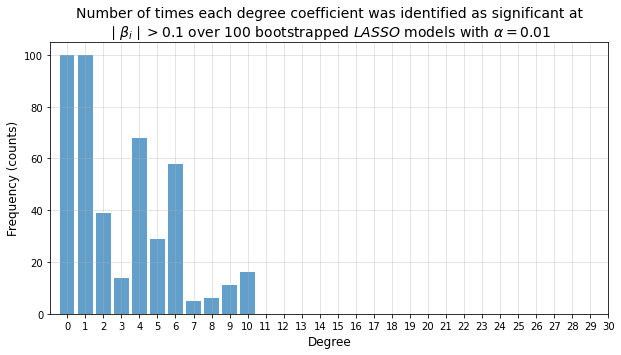

In [52]:
fig, ax = plt.subplots(figsize=(10,5))

lists = sorted(significant_degrees.items())

x, y = zip(*lists)

ax.bar(x, y, alpha=0.7)
ax.set_xlabel("Degree", fontsize=12)
ax.set_ylabel("Frequency (counts)", fontsize=12)
ax.set_xticks(range(max_degree+1))
ax.set_title(
    "Number of times each degree coefficient was identified as significant at\n"
    f"$\mid\\beta_i\mid > 0.1$ over {numboot} bootstrapped $LASSO$ models "
    f"with $\\alpha={best_alpha}$",
    fontsize=14,
)
plt.grid(":", alpha=0.4)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q6.4</b></div>

From our Question 6.3 results, we can see that only some degrees are consistently significant over many bootstraps.

- Use polynomial features based on the maximum degree you identified using your results from Question 6.3 (for the sake of simplicity, use all degrees up to that maximum degree as is typically done in polynomial regression).
- Train your **LASSO** regularized model using your `best_alpha` hyper-parameter on the entire training set.
- Append a new dictionary for this model to your `results` list.

_Points:_ 6

In [53]:
deg_chosen = 10

# design polynomial matrix
poly = PolynomialFeatures(deg_chosen, include_bias=False)
x_poly_train = poly.fit_transform(X_train)
x_poly_test = poly.fit_transform(X_test)

# lasso regression with best alpha
lasso_ = Lasso(fit_intercept=True, alpha=best_alpha)
lasso_.fit(x_poly_train, y_train)

# make predictions
y_train_pred = lasso_.predict(x_poly_train)
y_test_pred = lasso_.predict(x_poly_test)

# calculate MSE
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

def get_metrics4(model, name: str) -> dict:
    d = {}
    d['model'] = name
    d['train_mse'] = mean_squared_error(y_train, y_train_pred)
    d['test_mse'] = mean_squared_error(y_test, y_test_pred)
    return d


results.append(get_metrics4(lasso, '6.4'))

results_df = pd.DataFrame(results).set_index('model')
results_df



,train_mse,test_mse
model,,
2.2,2.661715,2.674863
3.4,2.490946,2.736483
4.3,2.512517,2.613011
5.4,2.512517,2.613011
6.4,2.537053,2.592273


In [54]:
grader.check("q6.4")

q6.4 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q6.5</b></div>

- Generate a plot of the data and your regression curve.
- Report the polynomial degrees and corresponding coefficients for this fully trained model that have an absolute value greater than 0.1 (i.e. $\mid\beta_i\mid \gt 0.1 $)
- Display `results` as a DataFrame.

_Points:_ 6

Polynomial degrees and corresponding coefficients are:
x^1 : 1.9752171615200025
x^2 : 0.44958158087272676
x^4 : 0.8292797602178414
x^6 : -0.22748917853733705
Intercept is: 1.428330850949246


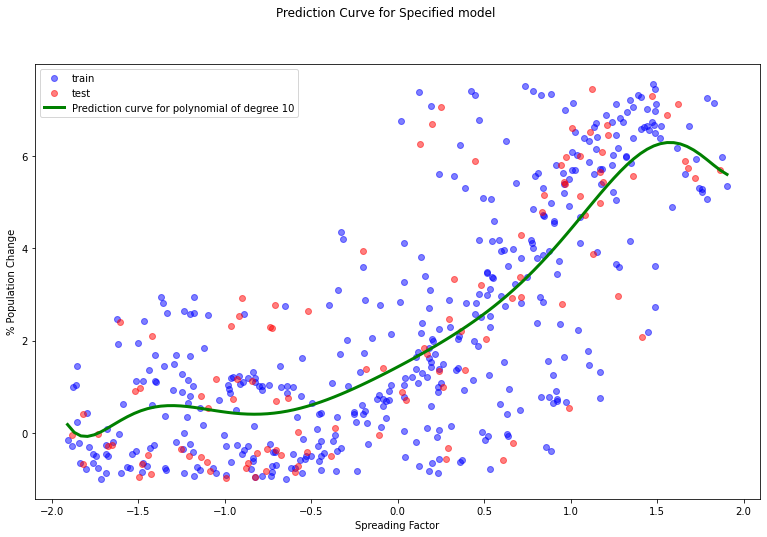

In [55]:
# We generate some data to predict on:

x_range = np.linspace(min(float(X_train.min()), float(X_test.min())), max(float(X_train.max()), float(X_test.max())), 100)



polynomial = PolynomialFeatures(degree= deg_chosen, include_bias=False)
x_train_poly = polynomial.fit_transform(X_train)
x_val_poly = polynomial.transform(X_test)

lasso_ = Lasso(fit_intercept=True, alpha=best_alpha)
lasso_.fit(x_poly_train, y_train)


prediction_curve = lasso_.predict(
    polynomial.transform(x_range.reshape(-1, 1))
)


plt.figure(figsize=(13,8))
plt.scatter(x=X_train, y=y_train, color="b", label="train", alpha=0.5)
plt.scatter(x=X_test, y=y_test, color="r", label="test", alpha=0.5)
plt.plot(x_range, prediction_curve, color="g", label=f"Prediction curve for polynomial of degree {deg_chosen}", linewidth=3)
plt.xlabel("Spreading Factor")
plt.ylabel("% Population Change")
plt.legend()
plt.suptitle(f"Prediction Curve for Specified model");


greater_than_val = lambda x: abs(x[1]) > 0.1

degrees_with_value_greater_than_1 = []
for x in lasso_.coef_:
    if abs(x) > 0.1:
        degrees_with_value_greater_than_1.append(x)
        
degrees_with_value_greater_than_1

x_s = ['x^1', 'x^2', 'x^4', 'x^6']


print("Polynomial degrees and corresponding coefficients are:")
for x, coef in zip(x_s, degrees_with_value_greater_than_1):
    print(x,':',coef)
    
print('Intercept is:', lasso_.intercept_[0])

In [56]:
print("Displaying results as DataFrame:")
results_df

Displaying results as DataFrame:


,train_mse,test_mse
model,,
2.2,2.661715,2.674863
3.4,2.490946,2.736483
4.3,2.512517,2.613011
5.4,2.512517,2.613011
6.4,2.537053,2.592273


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q6.6</b></div>

**What are your observations?**

- Compare your `best_degree` from [Question 5](#part5solutions) with your chosen degree in 6.4 above and comment on the difference.
- Compare your test $MSE$ in this question with the result from question 5. Which one is smaller, and by how much?
- Which degree coefficients in your best fit model from 6.4 are significant? If not all coefficients are significant, why?
- Would you expect your current model from 6.4 to be more "reliable" or robust than the models in Question 5 and prior? On what basis would you make a claim of its robustness?


_Points:_ 6

Choosing a degree that is 3 degrees less than the previous degree (12) results in a looser fit to the training data. However, it is worth noting here that this decrease in polynomial degree resulted in a decrease in test data MSE of approximately 0.1. This would enable one to argue that even though the model doesn't fit the data as closely, it is probably more reliable and accurate due to the fact that it has the lowest test MSE. 

The only significant coefficients are the intercept and Betas 1,2,4 and 6. The others are insignificant because we are unable to reject the null hypothesis that the coefficients are equal to 0. This is most likely attributable to their low predictive value. 

<!-- END QUESTION -->

<a id="part7"></a>

## <div class='exercise'>Question 7: Analyze your best test MSEs for each sub section of the homework [6 pts]</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q7.1</b></div>

Using the `results` list, generate a bar plot illustrating the test $MSE$ values for each of the models. Display `results` as a Dataframe as well.

_Points:_ 3

In [57]:
models = []
for i in results_df.index:
    models.append(i)

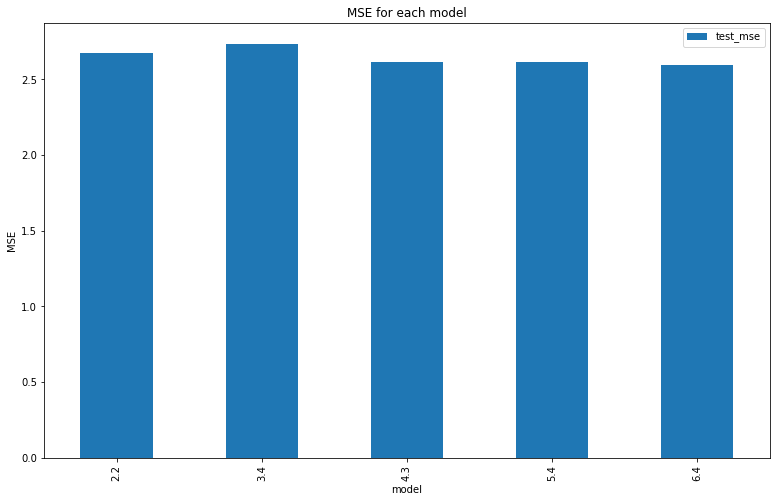

In [59]:
results_df.reset_index(inplace=True)
results_df.plot.bar(x='model', y="test_mse", ylabel="MSE", title="MSE for each model", figsize=(13,8));

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q7.2</b></div>

Which model do you think is best, and why? What are some of that model's drawbacks compared to the other models? 

_Points:_ 3

One may argue that model 6.4 is the best. The bar chart shows that it has the lowest test MSE, thus meaning that it is not prone to overfitting as may be the case with other models. 
This being said, it still has some major drawbacks.
Recall that the underlying mechanism is that it penalizes the sum of the absolute value of the coefficients in order to avoid overfitting. As a result, a regularized linear regression with fine tuned parameters will not overfit, meaning that the MSE of both the train and test set will be similar, which is the case here. However, this model is "automatic" and follows specific steps. One of these steps is that it ignores nonsignificant variables that may, nevertheless, be interesting or important. This may be the case here given the results that we obtained when we had to retrieve our most significant coefficients, two steps above. 
Another drawback may be the complexity in computing it, which may be an issue regarding cost/performance especially at a larger scale (e.g., in production at a large company). In this sense, the slightly lower MSE tradeoff may not make sense. 

<!-- END QUESTION -->

**This concludes HW3. Thank you!**

[Return to contents](#contents)